In [11]:
from sympy import symbols, init_printing,S,diff
init_printing()
from celmech.andoyer import Andoyer, AndoyerHamiltonian
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech.disturbing_function import get_fg_coeffs

import numpy as np

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Check transformations

In [13]:
import rebound
def get_sim(j,k):
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.G = 4*np.pi*np.pi
    mass=1e-5
    sim.add(m=mass,e=0.2,P=1)
    sim.add(m=mass,P=j / float(j-k),e=0.043,pomega= np.pi,l=np.pi/2.)
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim

In [14]:
j,k=5,1
sim = get_sim(j,k)
# get poincare sim
pvars=Poincare.from_Simulation(sim)
# convert poincare sim to andoyer
avars = Andoyer.from_Poincare(pvars,j,k,sim.particles[1].a)
# convert  andoyer back to poincare
pvars2=avars.to_Poincare()

Test $(\Lambda,\lambda)$ conversions

In [15]:
print([p.l for p in pvars.particles[1:]])
print([p.l for p in pvars2.particles[1:]])
print([p.Lambda for p in pvars.particles[1:]])
print([p.Lambda for p in pvars2.particles[1:]])

[2.3841857910156258e-08, 1.5707963267948981]
[2.3841857910156258e-08, 1.5707963267948981]
[6.2831957791114644e-05, 6.7683787558424789e-05]
[6.2831957791114644e-05, 6.7683787558424789e-05]


Test $(\Gamma,\gamma)$ conversions

In [16]:
print([p.Gamma for p in pvars.particles[1:]])
print([p.Gamma for p in pvars2.particles[1:]])
print([p.gamma for p in pvars.particles[1:]])
print([p.gamma for p in pvars2.particles[1:]])

[1.2694633397862748e-06, 6.260261304464002e-08]
[1.269463339786275e-06, 6.260261304464006e-08]
[-0.0, -3.1415926535897931]
[-1.224646799147353e-16, 3.1415926535897931]


# Check dynamics

Intialize Hamiltonians

In [17]:
Ha=AndoyerHamiltonian(avars)
Hp=PoincareHamiltonian(pvars)
Hp.add_all_resonance_subterms(1,2,j,k)

In [18]:
a10=avars.params['a10']
tFin,Nout=1e3,600
times = np.linspace(0,tFin,Nout)
ecc=np.zeros(Nout)
phi,Phi=np.zeros((2,Nout))
for i,t in enumerate(times):
    p = Hp.state.particles[1]
    ecc[i] = np.sqrt(2* p.Gamma / p.Lambda )
    Phi[i] = Andoyer.from_Poincare(Hp.state,j,k,a10).Phi
    phi[i] = Andoyer.from_Poincare(Hp.state,j,k,a10).phi
    Hp.integrate(t)

In [19]:
phiA,PhiA=np.zeros((2,Nout))
eccA=np.zeros(Nout)
tscale = abs(Ha.state.params['timescale'])
for i,t in enumerate(times):
    pvarsA = Ha.state.to_Poincare()
    p = pvarsA.particles[1]
    eccA[i] = np.sqrt(2* p.Gamma / p.Lambda )
    PhiA[i] = Ha.state.Phi
    phiA[i] = Ha.state.phi
    Ha.integrate(t/tscale)

## Plot results:

$\Phi$ shows agreement,

$e$ does not ($\lambda$ information is not being tracked when evolving Andoyer!)

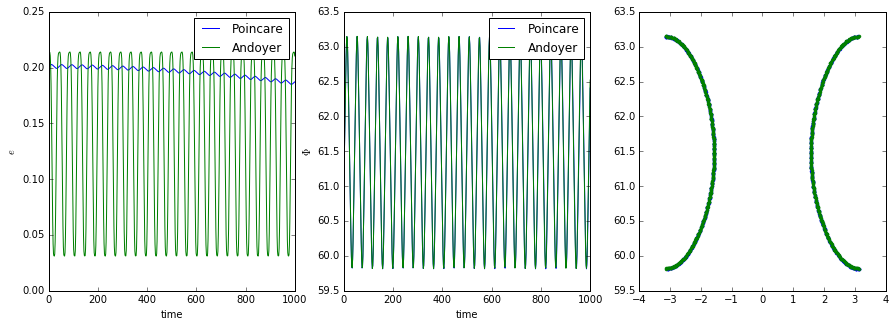

In [22]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(times,ecc,label='Poincare')
ax[0].plot(times,eccA,label='Andoyer')
ax[1].plot(times,Phi,label='Poincare')
ax[1].plot(times,PhiA,label='Andoyer')

ax[2].plot(phi,Phi,'.',label='Poincare')
ax[2].plot(phiA,PhiA,'.',label='Andoyer')



ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$e$')
ax[0].set_xlabel('time')
ax[1].set_ylabel('$\Phi$')
ax[1].set_xlabel('time')

In [14]:
from celmech.disturbing_function import get_fg_coeffs
from sympy import symbols,simplify,expand,diff

In [11]:
f,g = get_fg_coeffs(3,1)
G,m1,m2,Lambda1,Lambda2,M1,M2,Y1,Y2= symbols('G m1 m2 Lambda1 Lambda2 M1 M2 Y1 Y2')

In [12]:
poincare_params=(PHsim.Hparams).copy()
Lambda10,Lambda20=symbols("Lambda10 Lambda20")
poincare_params.update({Lambda1:Lambda10,Lambda2:Lambda20,Lambda10:pvars.particles[1].Lambda,Lambda20:pvars.particles[2].Lambda})

In [15]:
dfterm=expand(Lambda2**2* M1 * (PHsim.Hpolar-H0) / (m1 * G*G * M2 * M2 * m2**3 ))

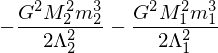

In [16]:
H0

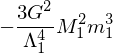

In [45]:
(-3 * diff(H0,Lambda1,1) / Lambda1)

In [75]:
(PHsim.H-H0).subs(poincare_params).subs([(Y1,0),(Y2,0)])

In [76]:
avars.params['Ccoeff']

In [67]:
Ac=(diff(H0,Lambda1,2).subs(Lambda1,Lambda10))*(j-k)**2 + (diff(H0,Lambda2,2).subs(Lambda2,Lambda20))*(j)**2

In [68]:
Ac.subs(poincare_params) / avars.params['Acoeff']

# Compare 'Poincare' and N-body

In [17]:
sim = Andoyer.to_Simulation(avars)
[p.e for p in sim.particles[1:]]

In [28]:
j=5
k=2
G = 4*np.pi**2
masses = [1., 3.e-5, 2.e-5]
a10=1

# eW sets script-W magnitude (roughly)
eW = 0.0
W = masses[2]*np.sqrt(G*masses[0])*eW*eW

avars = Andoyer.from_elements(j, k, 10, 0, a10, G, masses)
avars.Y = 0.2 * avars.X
# Induce finite libration amplitude by tweaking 'Y' initial condition


# numerical rebound simulation
sim = Andoyer.to_Simulation(avars)

# set up Poincare simulation
pvars = Poincare.from_Simulation(sim)
PHsim = PoincareHamiltonian(pvars)
PHsim.add_all_resonance_subterms(1,2,j,k)
PHsim.add_secular_terms(1,2,4)

# Set up Andoyer simulation
# AHsim = AndoyerHamiltonian(avars)

Norbits = 1e3
Nout = 500

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

ptimes = times / np.abs(avars.params['timescale'])
sign = np.sign(avars.params['timescale'])

# semi-major axis, eccentricity, Phi, and Phiprime variables over the course of simulations
# for A (Andoyer), P (Poincare), and N (Nbody)
Asma = np.zeros((2,Nout))
Aecc = np.zeros((2,Nout))
APhi = np.zeros((2,Nout))
APhiprime = np.zeros((2,Nout))

Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))
PPhi = np.zeros(Nout)
PPhiprime = np.zeros(Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
NPhi = np.zeros(Nout)
NPhiprime = np.zeros(Nout)


for i,t in enumerate(times):
    

    simP = PHsim.state.to_Simulation()
#     simA = AHsim.state.to_Simulation()    
#     Asma[0,i]=simA.particles[1].a
#     Asma[1,i]=simA.particles[2].a
#     Aecc[0,i]=simA.particles[1].e
#     Aecc[1,i]=simA.particles[2].e
    
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e
    
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e
    
    Pavars=Andoyer.from_Simulation(sim,j,k,a10=a10)
    NPhi[i], NPhiprime[i] = Pavars.Phi, Pavars.Phiprime

    Navars=Andoyer.from_Poincare(PHsim.state,j,k,a10)
    PPhi[i], PPhiprime[i] = Navars.Phi,Navars.Phiprime

  #  AHsim.integrate(ptimes[i])
    PHsim.integrate(times[i])
    sim.integrate(times[i])


Computing secular expansion to order 4...


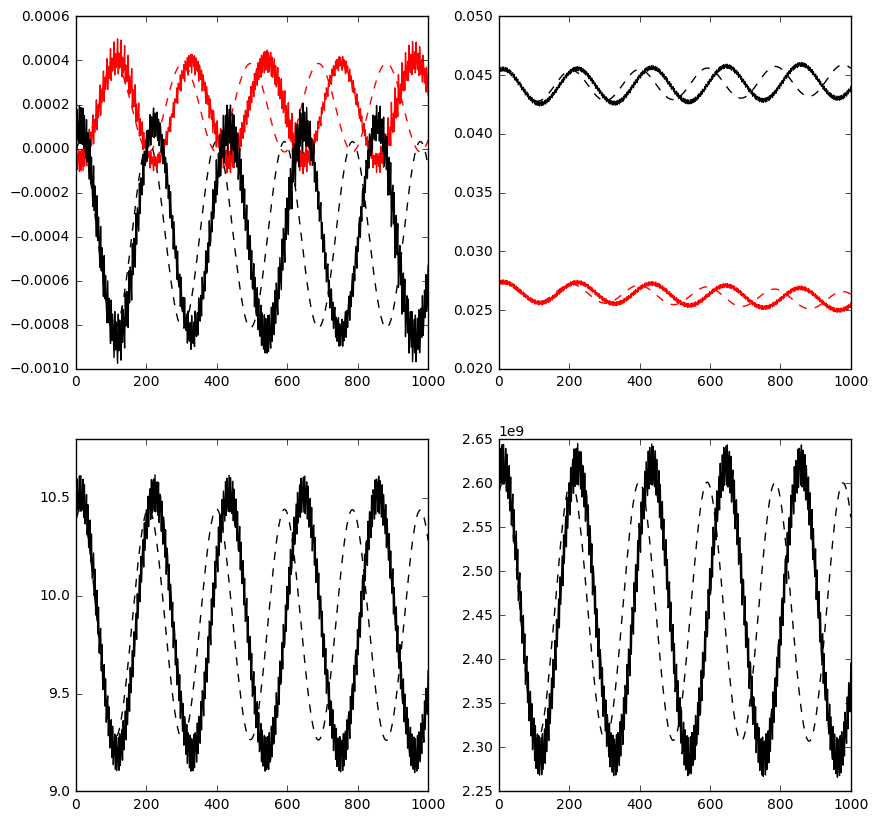

In [29]:
fig,ax=plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(times,(Psma[0]-Psma[0,0])/Psma[0,0],'r--')
ax[0,0].plot(times,(Psma[1]-Psma[1,0])/Psma[1,0],'k--')
ax[0,0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0,0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[0,1].plot(times,Pecc[0],'r--')
ax[0,1].plot(times,Pecc[1],'k--')
ax[0,1].plot(times,Necc[0],'r')
ax[0,1].plot(times,Necc[1],'k')

ax[1,0].plot(times,PPhi,'k--')
ax[1,0].plot(times,NPhi,'k')

ax[1,1].plot(times,PPhiprime,'k--')
ax[1,1].plot(times,NPhiprime,'k')

# Compare N-body, 'Poincare', and 'Andoyer'
Currently broken because ode package does not let Poincare and Andoyer be integrated at the same time (!?), have to comment out 'PHsim.integrate' or 'AHsim.integrate' in loop

In [10]:
j=5
k=2
G = 4*np.pi**2
masses = [1., 3.e-5, 3.e-6]
a10=1

# eW sets script-W magnitude (roughly)
eW = 0.01
W = masses[2]*np.sqrt(G*masses[0])*eW*eW

avars = Andoyer.from_elements(j, k, 10, 0, a10, G, masses,BB=W)

# Induce finite libration amplitude by tweaking 'X' initial condition
avars.X = avars.X-0.5


# numerical rebound simulation
sim = Andoyer.to_Simulation(avars)

# set up Poincare simulation
pvars = Poincare.from_Simulation(sim)
PHsim = PoincareHamiltonian(pvars)
PHsim.add_all_resonance_subterms(1,2,j,k)

# Set up Andoyer simulation
AHsim = AndoyerHamiltonian(avars)

Norbits = 3e3
Nout = 500

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

ptimes = times / np.abs(avars.params['timescale'])
sign = np.sign(avars.params['timescale'])

# semi-major axis, eccentricity, Phi, and Phiprime variables over the course of simulations
# for A (Andoyer), P (Poincare), and N (Nbody)
Asma = np.zeros((2,Nout))
Aecc = np.zeros((2,Nout))
APhi = np.zeros(Nout)
APhiprime = np.zeros(Nout)

Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))
PPhi = np.zeros(Nout)
PPhiprime = np.zeros(Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
NPhi = np.zeros(Nout)
NPhiprime = np.zeros(Nout)


for i,t in enumerate(times):
    

    simP = PHsim.state.to_Simulation()
    simA = AHsim.state.to_Simulation()    

    Asma[0,i]=simA.particles[1].a
    Asma[1,i]=simA.particles[2].a
    Aecc[0,i]=simA.particles[1].e
    Aecc[1,i]=simA.particles[2].e
    
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e
    
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e
    
    Pavars=Andoyer.from_Simulation(sim,j,k,a10=a10)
    NPhi[i], NPhiprime[i] = Pavars.Phi, Pavars.Phiprime

    Navars=Andoyer.from_Poincare(PHsim.state,j,k,a10)
    PPhi[i], PPhiprime[i] = Navars.Phi,Navars.Phiprime

    Aavars=AHsim.state
    APhi[i], APhiprime[i] = Aavars.Phi,Aavars.Phiprime

    AHsim.integrate(ptimes[i])
    #
    # Currently, PHsim can't integrate backwards (needed for direct comparison with 
    # AHsim) because of condition in hamiltonian.py.  This issue is separate from inability
    # to integrate both AHsim and PHsim at the same time.
    #
    #-------------- UNCOMMENT FOR POINCARE INTEGRATION -----------------
    #PHsim.integrate(times[i])
    #-------------------------------------------------------------------
    sim.integrate(sign*times[i])


Disagreement between libration amplitdues in lower-left panel seems fishy... the agreement between N-body and Poincare is much better in the above section. 

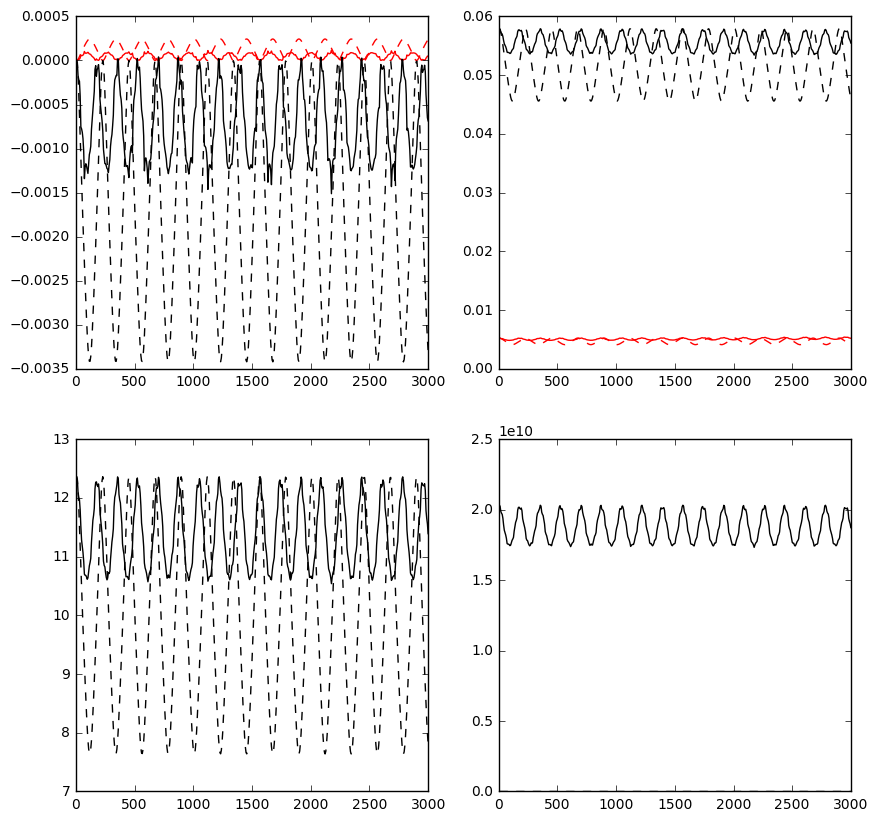

In [11]:
fig,ax=plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(times,(Asma[0]-Asma[0,0])/Asma[0,0],'r--')
ax[0,0].plot(times,(Asma[1]-Asma[1,0])/Asma[1,0],'k--')
ax[0,0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0,0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[0,1].plot(times,Aecc[0],'r--')
ax[0,1].plot(times,Aecc[1],'k--')
ax[0,1].plot(times,Necc[0],'r')
ax[0,1].plot(times,Necc[1],'k')

ax[1,0].plot(times,APhi,'k--')
ax[1,0].plot(times,NPhi,'k')

ax[1,1].plot(times,APhiprime,'k--')
ax[1,1].plot(times,NPhiprime,'k')


Compare Andoyer with Poincare

In [3]:
j,k=3,1
import rebound
def get_sim(j,k):
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.G = 4*np.pi*np.pi
    mass=1e-5
    sim.add(m=mass,e=0.01,P=1)
    sim.add(m=mass,P=j / float(j-k),e=0.1,pomega=np.pi)
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim

In [4]:
sim = get_sim(j,k)
pvars=Poincare.from_Simulation(sim)
PHsim=PoincareHamiltonian(pvars)
PHsim.add_all_resonance_subterms(1,2,j,k)
PHsim.add_all_resonance_subterms(1,2,2*j,2*k)
PHsim.add_all_resonance_subterms(1,2,3*j,3*k)
PHsim.add_secular_terms(1,2,2)

Norbits = 3e3
Nout = 500

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))

for i,t in enumerate(times):
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e
    simP=PHsim.state.to_Simulation()
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e

    sim.integrate(times[i])
    PHsim.integrate(times[i])


Computing secular expansion to order 2...


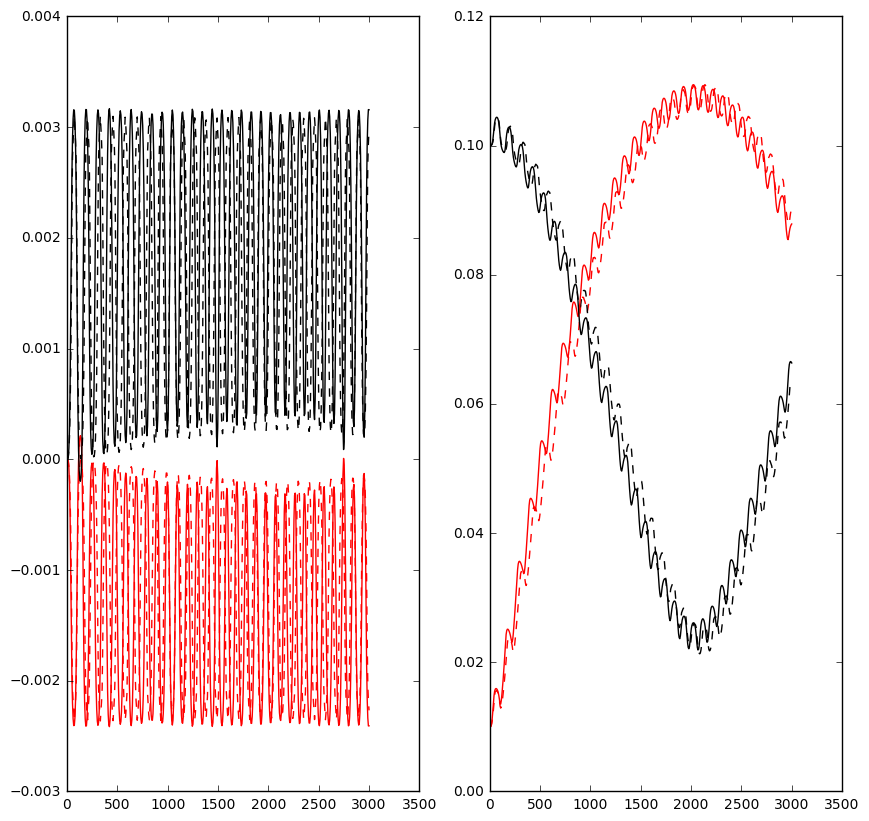

In [5]:
fig,ax=plt.subplots(1,2,figsize=(10,10))

ax[0].plot(times,(Psma[0]-Psma[0,0])/Psma[0,0],'r--')
ax[0].plot(times,(Psma[1]-Psma[1,0])/Psma[1,0],'k--')

ax[0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[1].plot(times,Pecc[0],'r--')
ax[1].plot(times,Pecc[1],'k--')

ax[1].plot(times,Necc[0],'r')
ax[1].plot(times,Necc[1],'k')

In [6]:
sim = get_sim(j,k)
pvars=Poincare.from_Simulation(sim)
AHam=AndoyerHamiltonian(Andoyer.from_Poincare(pvars,3,1,1.0))
AHam2=AndoyerHamiltonian(Andoyer.from_Simulation(sim,3,1))

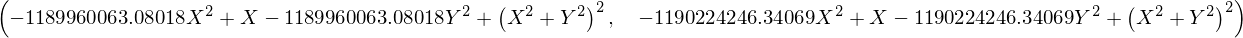

In [7]:
(AHam2.NH,AHam.NH)